In [54]:
import os
import json
import numpy as np
import nibabel as nib
import pandas as pd

from glob import glob

In [55]:
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')

bidsroot = os.path.join(project_dir, 'data_denoised')
deriv_dir = os.path.join(bidsroot, 'derivatives')
fmriprep_dir = os.path.join(deriv_dir, 'denoised_fmriprep-22.1.1')

nilearn_dir = os.path.join(deriv_dir, 'nilearn')
print(nilearn_dir)

mask_dir = os.path.join(project_dir, 'data_bids', 'derivatives', 'nilearn', 'masks')

task_list = ['tonecat']

/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn


In [3]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT27',
               'sub-FLT07', # bad QA 11/14/23
               'sub-FLT02', # missing resp_6 in run00 (pressing wrong keys)
               #'sub-FLT10', # MISSING 11/16/23
               #'sub-FLT01', 'sub-FLT16',  
               #'sub-FLT19', 'sub-FLT20',
               #'sub-FLT28', 'sub-FLT30',
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

In [4]:
participants_df

,participant_id,age,sex,group,FFR_id
0,sub-FLT03,25,F,Mandarin,2002.0
1,sub-FLT04,21,F,non-Mandarin,1003.0
2,sub-FLT05,26,M,Mandarin,3010.0
3,sub-FLT06,21,F,non-Mandarin,3001.0
4,sub-FLT08,23,F,Mandarin,2005.0
5,sub-FLT09,30,F,non-Mandarin,3002.0
6,sub-FLT10,23,F,Mandarin,2006.0
7,sub-FLT11,20,F,non-Mandarin,1005.0
8,sub-FLT12,20,F,non-Mandarin,3004.0
9,sub-FLT13,23,F,non-Mandarin,3005.0


In [5]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])
sub_dict = {'Mandarin': sub_list_mand, 'non-Mandarin': sub_list_nman}

## define anatomical masks

In [6]:
network_name = 'tian_subcortical_S3' # auditory

if network_name == 'auditory':
    roi_list = [
                'L-IC', 'L-MGN', 'L-HG', 'L-PT',  'L-PP', 'L-STGp', 'L-STGa', 'L-ParsOp', 'L-ParsTri',
                'R-IC', 'R-MGN', 'R-HG', 'R-PT',  'R-PP', 'R-STGp', 'R-STGa', 'R-ParsOp', 'R-ParsTri', 
               ]
elif network_name == 'aud-striatal':
    roi_list = ['L-Caud', 'L-Put', 'L-IC', 'L-MGN',
                'L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 
                'L-ParsOp', 'L-ParsTri',
                'R-Caud', 'R-Put','R-IC', 'R-MGN',
                'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', 
                'R-ParsOp', 'R-ParsTri',
               ]
elif network_name == 'tian_subcortical_S3':
    roi_list = [
                'CAU-DA-lh', 'CAU-VA-lh', 'pCAU-lh', 
                'PUT-DA-lh', 'PUT-DP-lh', 'PUT-VA-lh', 'PUT-VP-lh',
                'aGP-lh', 'pGP-lh', 'NAc-core-lh', 'NAc-shell-lh',
                'CAU-DA-rh', 'CAU-VA-rh', 'pCAU-rh', 
                'PUT-DA-rh', 'PUT-DP-rh', 'PUT-VA-rh', 'PUT-VP-rh',
                'aGP-rh', 'pGP-rh', 'NAc-core-rh', 'NAc-shell-rh', 
               ]

## Define data and labels

In [7]:
def create_labels(stat_maps):
    import os
    from glob import glob
    from numpy.random import shuffle
    from copy import copy
    
    # 16 stimulus decoding
    #conditions_all = [os.path.basename(x)[-31:-18] for x in stat_maps] 
    conditions_all = ['_'.join(os.path.basename(x).split('_')[5:8]) for x in (stat_maps)]
    #print('all events: ', conditions_all[:10])

    # 4-category decoding
    conditions_tone = [os.path.basename(x).split('_')[5] for x in (stat_maps)]

    conditions_talker = [os.path.basename(x).split('_')[6] for x in (stat_maps)]
    
    # shuffled conditions
    conditions_shuffled = copy(conditions_tone)
    shuffle(conditions_shuffled)

    return conditions_tone, conditions_talker, conditions_all, conditions_shuffled

## Decoding

### scikit learn

In [8]:
def mask_fmri(fmri_niimgs, mask_filename, fwhm):
    from nilearn.maskers import NiftiMasker
    masker = NiftiMasker(mask_img=mask_filename, #runs=session_label,
                         smoothing_fwhm=fwhm, standardize=True,
                         #memory="nilearn_cache", memory_level=1
                        )
    fmri_masked = masker.fit_transform(fmri_niimgs)
    return fmri_masked, masker

In [9]:
# NOT CURRENTLY USED
def sub_region_svc(sub_id, mask_fpath, stat_maps, cv, fwhm=1.5, space_label='T1w'):
    from sklearn.svm import SVC
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import permutation_test_score

    #print(sub_id)
    #print(os.path.basename(mask_fpath))
          
    conditions_tone, conditions_talker, conditions_all, conditions_shuffled = create_labels(stat_maps)

    # extract beta values from stat maps for given region of interest
    fmri_masked, masker = mask_fmri(stat_maps, mask_fpath, fwhm_sub)

    svc = SVC()

    tone_cv_scores = cross_val_score(svc, fmri_masked, conditions_tone, cv=cv)
    print("Tone SVC accuracy: {:.3f} with a standard deviation of {:.2f}".format(tone_cv_scores.mean(),tone_cv_scores.std()))

    talker_cv_scores = cross_val_score(svc, fmri_masked, conditions_talker, cv=cv)
    print("Talker SVC accuracy: {:.3f} with a standard deviation of {:.2f}".format(talker_cv_scores.mean(),talker_cv_scores.std()))

    null_cv_scores = permutation_test_score(svc, fmri_masked, conditions_tone, cv=cv, )[1]
    print("Permutation test score: {:.3f} with a standard deviation of {:.2f}".format(null_cv_scores.mean(),null_cv_scores.std()))
    
    #plot_confusion_matrix(fmri_masked, conditions_tone, mask_descrip, sub_id)
    #plot_confusion_matrix(fmri_masked, conditions_talker, mask_descrip, sub_id)
    
    return fmri_masked, tone_cv_scores, talker_cv_scores, null_cv_scores

#### Confusion matrix

In [10]:
def plot_confusion_matrix(X, y, mask_descrip, sub_id):
    import numpy as np
    import matplotlib.pyplot as plt

    from sklearn import svm, datasets
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import ConfusionMatrixDisplay

    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        random_state=0, stratify=y)

    # Run classifier, using a model that is too regularized (C too low) to see
    # the impact on the results
    classifier = svm.SVC(kernel="linear", ).fit(X_train, y_train)

    np.set_printoptions(precision=2)

    sub_title = 'sub-%s mask-%s'%(sub_id, mask_descrip)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", "true"),]
    #for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            #display_labels=class_names,
            cmap=plt.cm.Blues,
            #normalize='true', 
            )
    disp.ax_.set_title(sub_title)

    #print(title)
    #print(disp.confusion_matrix)

    #plt.show()
    
    return disp.confusion_matrix

#### Confusion matrices across regions

In [11]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

fwhm_sub = 0.00
space_label = 'MNI152NLin2009cAsym'

model_desc = 'trial_models_LSS' # 'stimulus_per_run_LSS'
maptype = 'tstat'
split_design = 'random'

sub_list_temp = participants_df.participant_id.to_list()
sub_list = [x.split('-')[1] for x in sub_list_temp]

print(roi_list)
num_rois = len(roi_list)

['CAU-DA-lh', 'CAU-VA-lh', 'pCAU-lh', 'PUT-DA-lh', 'PUT-DP-lh', 'PUT-VA-lh', 'PUT-VP-lh', 'aGP-lh', 'pGP-lh', 'NAc-core-lh', 'NAc-shell-lh', 'CAU-DA-rh', 'CAU-VA-rh', 'pCAU-rh', 'PUT-DA-rh', 'PUT-DP-rh', 'PUT-VA-rh', 'PUT-VP-rh', 'aGP-rh', 'pGP-rh', 'NAc-core-rh', 'NAc-shell-rh']


In [48]:
# options: 'sound', 'resp', 'fb' (only available for non-Mandarin speakers)
contrast_label = 'fb'

In [49]:
out_dir = os.path.join(
                       bidsroot, 'derivatives', 'nilearn', 
                       'level-1_fwhm-%.02f'%fwhm_sub,
                       'level-1_den_mvpc-roi',
                       network_name,
                       f'contrast-{contrast}',)
os.makedirs(out_dir, exist_ok=True)

In [50]:
print(out_dir)

/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/level-1_den_mvpc-roi/tian_subcortical_S3/contrast-resp


grp-Mandarin sub-FLT03
# of stat maps:  275
['/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT03_space-MNI152NLin2009cAsym/trial_models_LSS/run00/sub-FLT03_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-fb_correct_trial10_run00_model-LSS_map-tstat.nii.gz', '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT03_space-MNI152NLin2009cAsym/trial_models_LSS/run00/sub-FLT03_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-fb_correct_trial11_run00_model-LSS_map-tstat.nii.gz', '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT03_space-MNI152NLin2009cAsym/trial_models_LSS/run00/sub-FLT03_task-tonecat_fwhm-0.00_space-MNI152NLin2009cAsym_contrast-fb_correct_trial12_run00_model-LSS_map-tstat.nii.gz', '/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT03_space-MNI152NLin2009cAsym/trial_models

KeyboardInterrupt: 

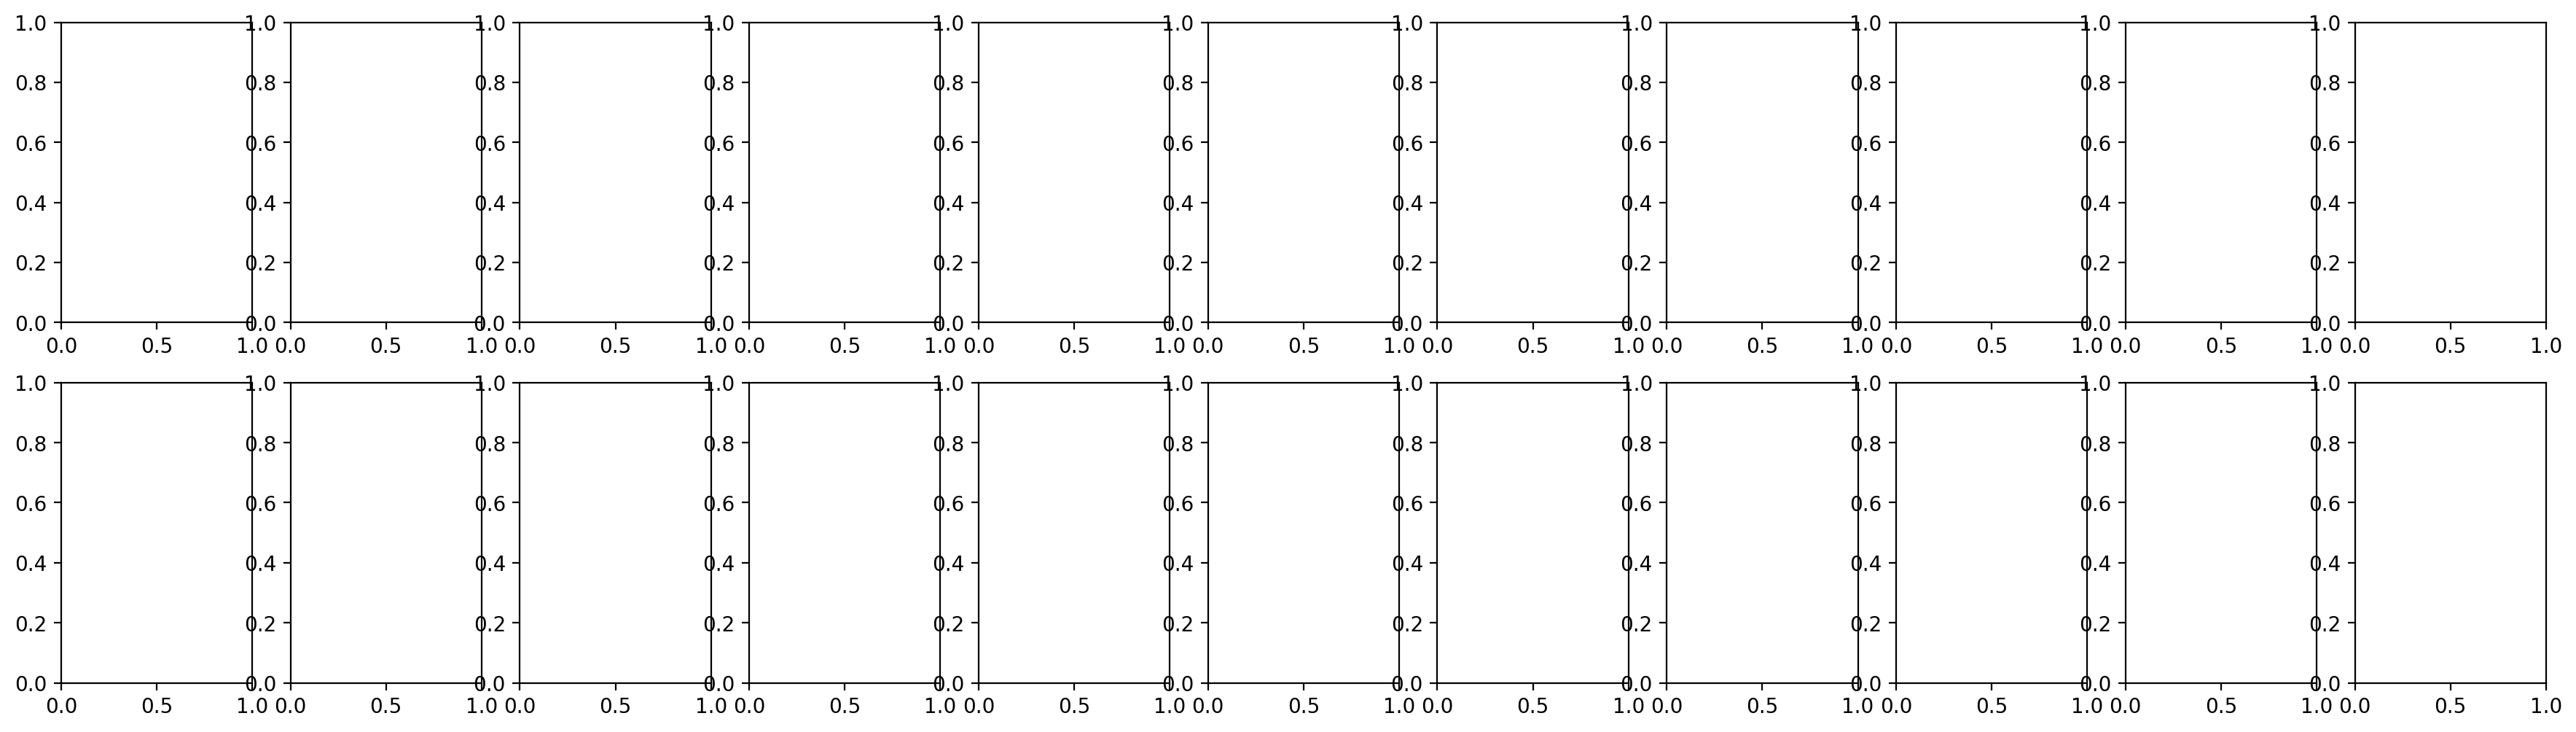

In [53]:
mand_conf_mat = []
nman_conf_mat = []
for group_id, vals in sub_dict.items(): # ['FLT07'] # sub_list
    for sub_id in vals:
        print(f'grp-{group_id} {sub_id}')
        sub_conf_mat = []

        fig, axs = plt.subplots(nrows=2, ncols=round(num_rois/2), 
                                figsize=(num_rois,6), dpi=200)

        nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                           'level-1_fwhm-%.02f'%fwhm_sub, 
                                           '%s_space-%s'%(sub_id, space_label))

        # grab stat maps
        stat_maps = sorted(glob(nilearn_sub_dir+f'/{model_desc}/run*/*{contrast_label}*map-{maptype}.nii.gz')) 
        print('# of stat maps: ', len(stat_maps))    
        print(stat_maps)

        # generate condition labels based on filenames
        conditions_tone, conditions_talker, conditions_all, conditions_shuffled = create_labels(stat_maps)
        print(conditions_tone)

        for mx, mask_descrip in enumerate(roi_list):
            # define the mask for the region of interest
            print(mask_descrip)
            masks_dir = os.path.join(mask_dir, '%s'%sub_id, 'space-%s'%space_label)
            mask_fpath = glob(masks_dir + '/masks-*/' + '%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))[0]

            fmri_masked, masker = mask_fmri(stat_maps, mask_fpath, fwhm_sub)

            # Split the data into a training set and a test set
            x, y = fmri_masked, conditions_tone
            if split_design == 'random':

                X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                                    test_size=0.25,
                                                                    random_state=0, 
                                                                    stratify=y)

            elif split_design == 'talker-sex':
                # split into male and female talker stimuli
                stim_m_indices = [i for i, s in enumerate(conditions_all) if any(xs in s for xs in ['aN', 'bN'])]
                stim_f_indices = [i for i, s in enumerate(conditions_all) if any(xs in s for xs in ['hN', 'iN'])]

                # train male, test female
                X_train = x[stim_m_indices]
                y_train = [y[i] for i in stim_m_indices]
                X_test = x[stim_f_indices]
                y_test = [y[i] for i in stim_f_indices]

            # Run classifier
            clf = svm.SVC(decision_function_shape='ovo').fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            clf_acc = accuracy_score(y_test, y_pred)
            print(f'accuracy: {clf_acc:.04f}')

            ax = plt.subplot(2, num_rois/2, mx + 1)
            ax.set_title(f'{mask_descrip} \n acc = {clf_acc:.04f}')
            cm = confusion_matrix(y_test, y_pred, normalize='true',)
            #np.savetxt(os.path.join(out_dir, '{}_mask-{}_label-{}_split-{}_confusion_matrix.csv'.format(sub_id, mask_descrip, 'tone', split_design)), cm)
            
            cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                                                 ax=ax, 
                                                                  colorbar=False, 
                                                                  im_kw={'cmap':'Blues'},
                                                                  display_labels=['T1', 'T2', 'T3', 'T4'],
                                                                  include_values=False)
            

            sub_conf_mat.append(cm)
        # update figure suptitle
        fig.suptitle(f'group-{group_id} {sub_id}')
        # better spacing
        fig.tight_layout()

        #fig_fname = f'grp-{group_id}_{sub_id}_auditory_label-tone_split-{split_design}_confusion_matrices.png'
        fig.savefig(os.path.join(out_dir, fig_fname))

        # append to group list
        if sub_id in sub_list_mand:
            mand_conf_mat.append(sub_conf_mat)
        elif sub_id in sub_list_nman:
            nman_conf_mat.append(sub_conf_mat)

### Group mean matrices

In [ ]:
'''
mand_mean_cm = np.mean(mand_conf_mat, axis=0)
nman_mean_cm = np.mean(nman_conf_mat, axis=0)
'''

#### Read in pre-generated single-subject, single-ROI confusion matrices

In [35]:
mand_acc_dict = dict()
mand_cm_dict = dict()
for rx, roi in enumerate(roi_list):
    mand_acc = []
    subroi_list = []
    for sx, sub_id in enumerate(sub_list_mand):
        fpath = os.path.join(out_dir, #'level-1_mvpc-roi',
                             #f'{sub_id}_mask-{roi}_label-tone_split-{split_design}_confusion_matrix.csv',
                             f'{sub_id}_mask-{roi}_contrast-{contrast_label}_label-tone_confusion_matrix.csv',
                            )
        sr_data = np.genfromtxt(fpath)
        subroi_list.append(sr_data)
        
        sub_acc = np.diag(sr_data).mean()
        mand_acc.append(sub_acc)
    mand_subroi = np.array(subroi_list)
    mean_roi = mand_subroi.mean(axis=0)
    mand_cm_dict[roi] = mean_roi
    mand_acc_dict[roi] = mand_acc

nman_acc_dict = dict()
nman_cm_dict = dict()
for rx, roi in enumerate(roi_list):
    nman_acc = []
    subroi_list = []
    for sx, sub_id in enumerate(sub_list_nman):
        fpath = os.path.join(out_dir, #'level-1_mvpc-roi',
                             #f'{sub_id}_mask-{roi}_label-tone_split-{split_design}_confusion_matrix.csv',
                             f'{sub_id}_mask-{roi}_contrast-{contrast_label}_label-tone_confusion_matrix.csv',
                            )
        sr_data = np.genfromtxt(fpath)
        subroi_list.append(sr_data)
        
        sub_acc = np.diag(sr_data).mean()
        nman_acc.append(sub_acc)
    mand_subroi = np.array(subroi_list)
    mean_roi = mand_subroi.mean(axis=0)
    nman_cm_dict[roi] = mean_roi
    nman_acc_dict[roi] = nman_acc

#### Group-specific stats

In [47]:
from scipy import stats

mean_accs = []
p_vals = []
t_stats = []
print(f'Native Mandarin mean SVC accuracy')
for rx, roi in enumerate(roi_list):
    mand_roi_acc = np.array(mand_acc_dict[roi])
    mean_acc = mand_roi_acc.mean()
    
    ttest_res = stats.ttest_1samp(mand_roi_acc, popmean=0.25)
    print(f'mean SVC accuracy = {mean_acc:.04f} p = {ttest_res.pvalue:.04f} t = {ttest_res.statistic:.02f} region = {roi}')
    
    mean_accs.append(mean_acc)
    p_vals.append(ttest_res.pvalue)
    t_stats.append(ttest_res.statistic)

p_vals_adj = stats.false_discovery_control(p_vals)
for rx, roi in enumerate(roi_list):
    print(f'mean SVC accuracy = {mean_accs[rx]:.04f} t = {t_stats[rx]:.02f} FDR-corrected p = {p_vals_adj[rx]:.04f} region = {roi}')

mean_accs = []
p_vals = []
t_stats = []
print(f'Non-Mandarin mean SVC accuracy')
for rx, roi in enumerate(roi_list):
    nman_roi_acc = np.array(nman_acc_dict[roi])
    mean_acc = nman_roi_acc.mean()
    
    ttest_res = stats.ttest_1samp(nman_roi_acc, popmean=0.25)
    print(f'mean SVC accuracy = {mean_acc:.04f} p = {ttest_res.pvalue:.04f} t = {ttest_res.statistic:.02f} region = {roi}')
    
    mean_accs.append(mean_acc)
    p_vals.append(ttest_res.pvalue)
    t_stats.append(ttest_res.statistic)

p_vals_adj = stats.false_discovery_control(p_vals)
for rx, roi in enumerate(roi_list):
    print(f'mean SVC accuracy = {mean_accs[rx]:.04f} t = {t_stats[rx]:.02f} FDR-corrected p = {p_vals_adj[rx]:.04f} region = {roi}')

Native Mandarin mean SVC accuracy
mean SVC accuracy = 0.2798 p = 0.0634 t = 2.04 region = CAU-DA-lh
mean SVC accuracy = 0.2603 p = 0.4336 t = 0.81 region = CAU-VA-lh
mean SVC accuracy = 0.2762 p = 0.0501 t = 2.18 region = pCAU-lh
mean SVC accuracy = 0.2654 p = 0.1411 t = 1.58 region = PUT-DA-lh
mean SVC accuracy = 0.2377 p = 0.2001 t = -1.36 region = PUT-DP-lh
mean SVC accuracy = 0.2599 p = 0.5903 t = 0.55 region = PUT-VA-lh
mean SVC accuracy = 0.2428 p = 0.6665 t = -0.44 region = PUT-VP-lh
mean SVC accuracy = 0.2322 p = 0.1391 t = -1.58 region = aGP-lh
mean SVC accuracy = 0.2523 p = 0.8661 t = 0.17 region = pGP-lh
mean SVC accuracy = 0.2566 p = 0.4919 t = 0.71 region = NAc-core-lh
mean SVC accuracy = 0.2725 p = 0.0746 t = 1.95 region = NAc-shell-lh
mean SVC accuracy = 0.2629 p = 0.4016 t = 0.87 region = CAU-DA-rh
mean SVC accuracy = 0.2810 p = 0.0299 t = 2.46 region = CAU-VA-rh
mean SVC accuracy = 0.2543 p = 0.7486 t = 0.33 region = pCAU-rh
mean SVC accuracy = 0.2371 p = 0.4265 t = -0

In [37]:
l2_dir = os.path.join(nilearn_dir, 'level-2_den_mvpc-roi/')
os.makedirs(l2_dir, exist_ok=True)

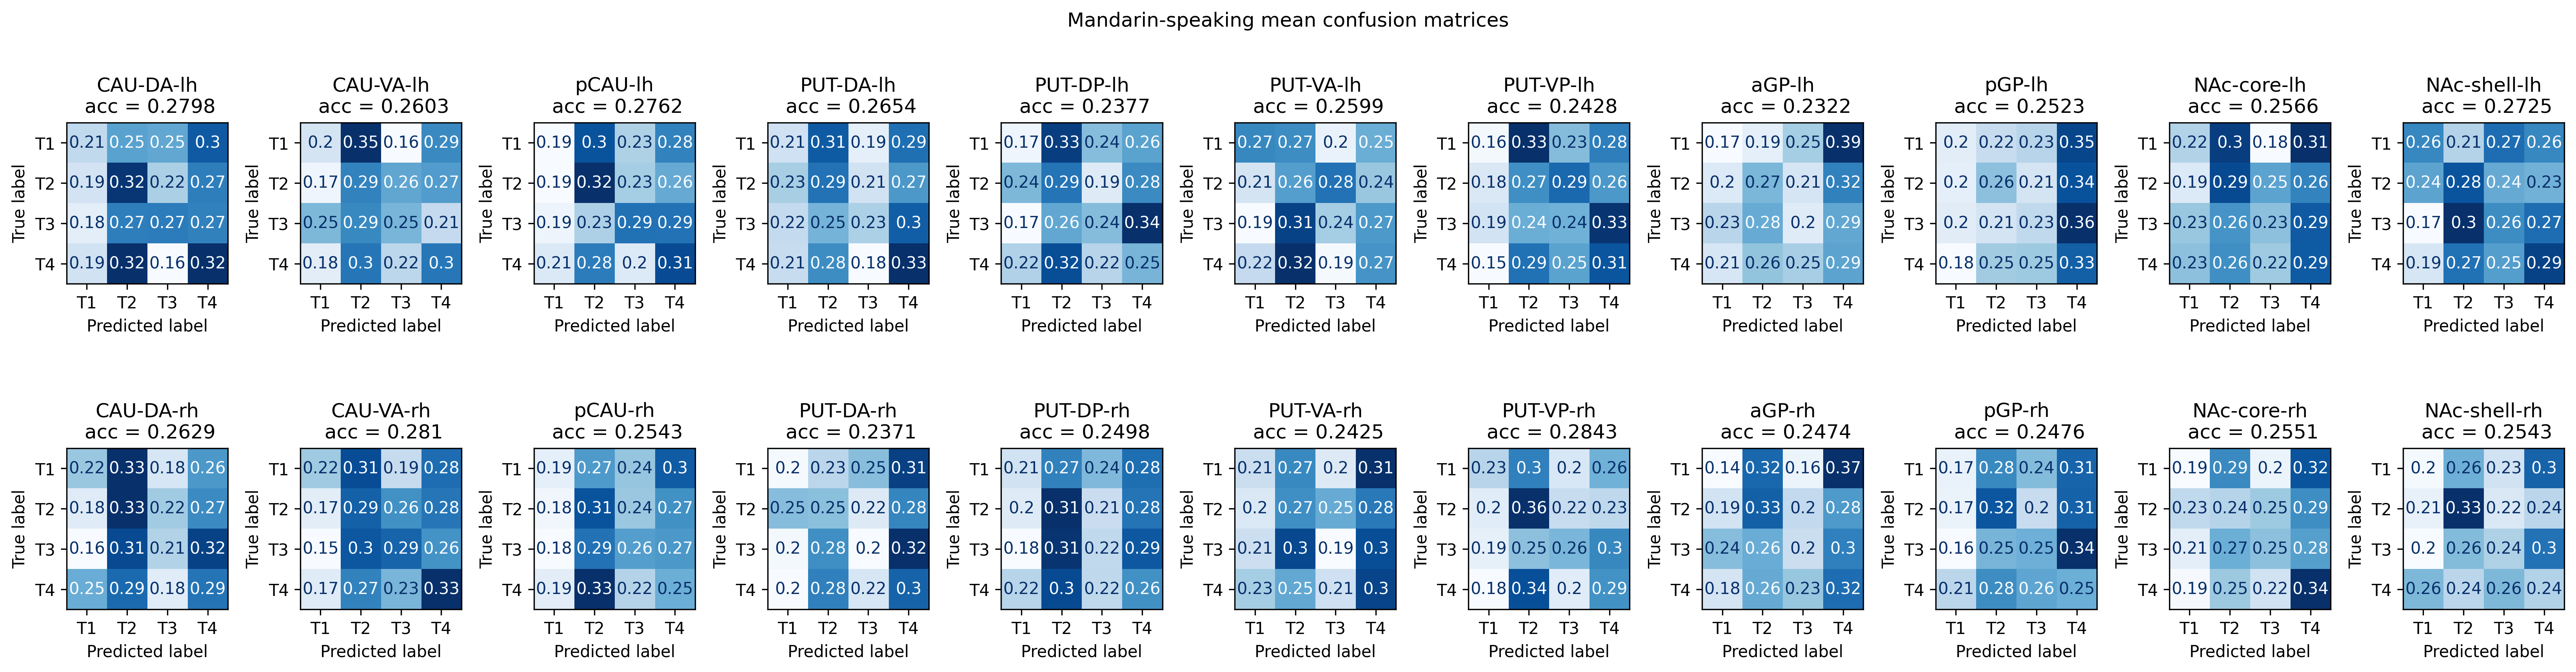

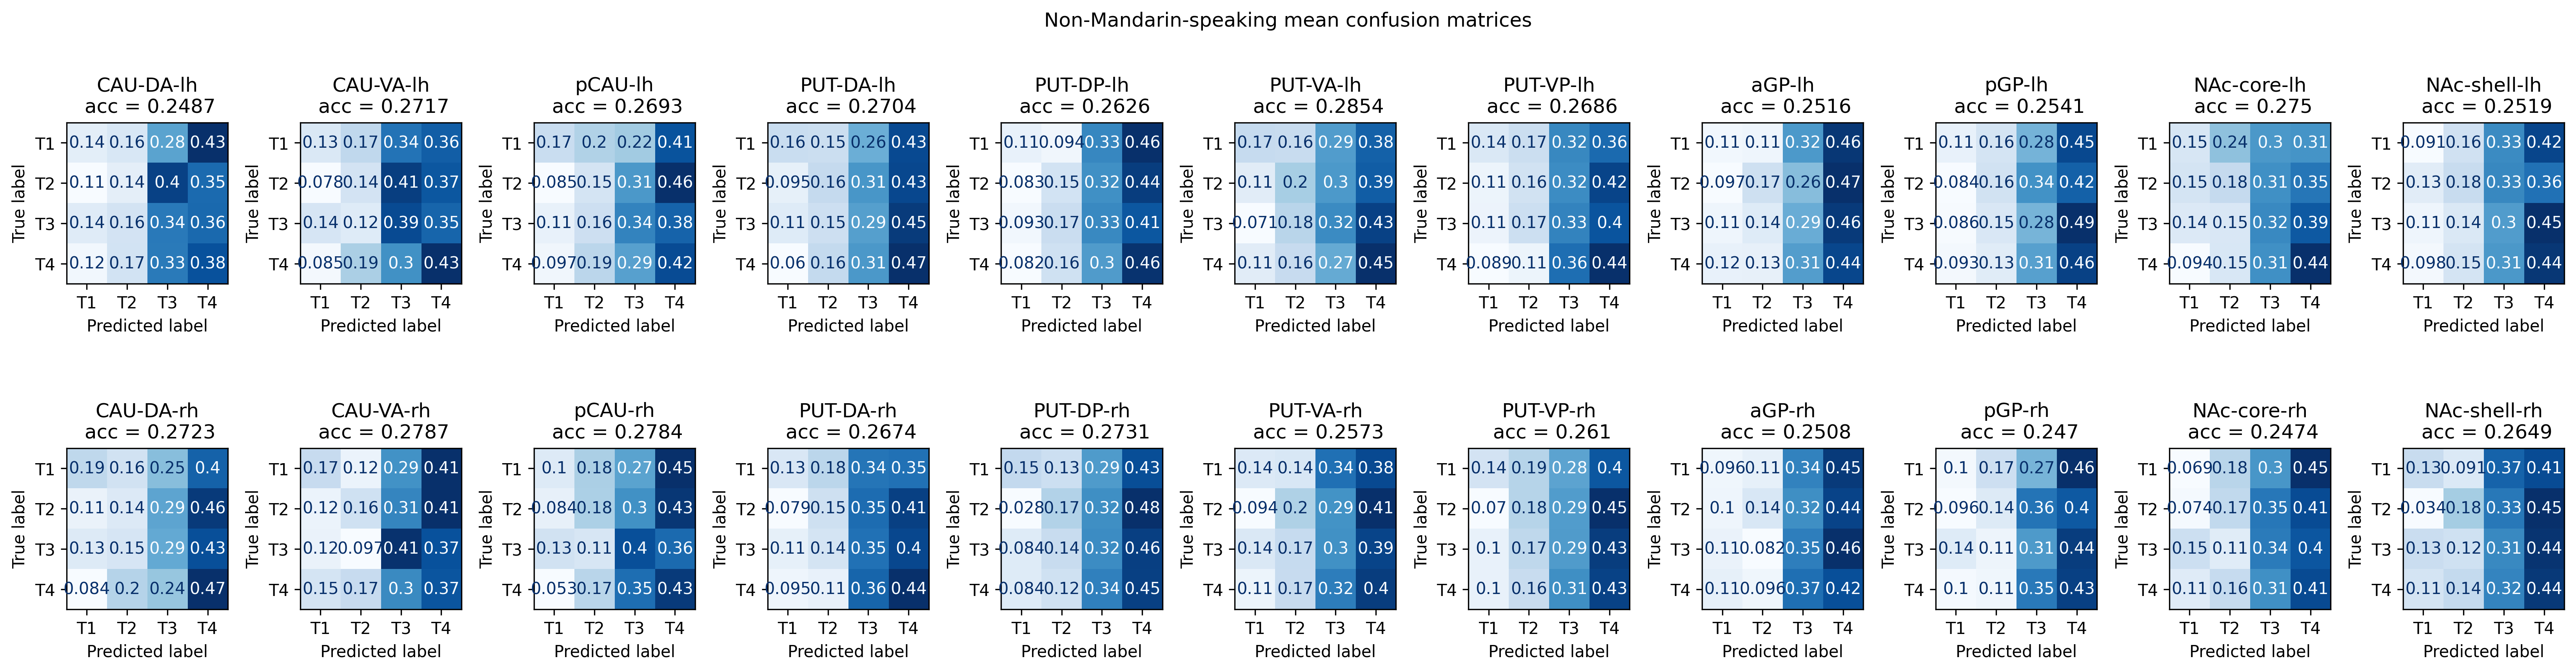

In [38]:
# Mandarin-speaking participants
fig, axs = plt.subplots(nrows=2, ncols=round(num_rois/2), figsize=(num_rois,6), dpi=300)
fig.suptitle('Mandarin-speaking mean confusion matrices')

for mx, mask_descrip in enumerate(roi_list):
    ax = plt.subplot(2, num_rois/2, mx + 1)
    ConfusionMatrixDisplay(mand_cm_dict[mask_descrip],).plot(ax=ax, colorbar=False, 
                                                   im_kw={'cmap':'Blues', },
                                                   include_values=True)
    roi_mean = np.diag(mand_cm_dict[mask_descrip]).mean()
    ax.set_title(f'{mask_descrip}\n acc = {roi_mean:.04}')
    ax.set_xticklabels(['T1','T2','T3','T4'])
    ax.set_yticklabels(['T1','T2','T3','T4'])
# better spacing
fig.tight_layout()
fig.savefig(l2_dir + '/' + f'group-Mand_{network_name}_split-{split_design}_label-tone_incl-vals_confusion_matrices.png')

# Non-Mandarin-speaking participants
fig2, axs = plt.subplots(nrows=2, ncols=round(num_rois/2), figsize=(num_rois,6), dpi=300)
fig2.suptitle('Non-Mandarin-speaking mean confusion matrices')

for mx, mask_descrip in enumerate(roi_list):
    ax = plt.subplot(2, num_rois/2, mx + 1)
    ConfusionMatrixDisplay(nman_cm_dict[mask_descrip],).plot(ax=ax, colorbar=False, 
                                                   im_kw={'cmap':'Blues', },
                                                   include_values=True)
    roi_mean = np.diag(nman_cm_dict[mask_descrip]).mean()
    ax.set_title(f'{mask_descrip}\n acc = {roi_mean:.04}')
    ax.set_xticklabels(['T1','T2','T3','T4'])
    ax.set_yticklabels(['T1','T2','T3','T4'])
# better spacing
fig2.tight_layout()
fig2.savefig(l2_dir + '/' + f'group-NMan_{network_name}_split-{split_design}_label-tone_incl-vals_confusion_matrices.png')

### Combine all subjects

In [44]:
all_cm_dict = dict()
all_acc_dict = dict()
for rx, roi in enumerate(roi_list):
    all_acc = []
    subroi_list = []
    for sx, sub_id in enumerate(sub_list_mand+sub_list_nman):
        fpath = os.path.join(out_dir, #'level-1_mvpc-roi',
                             #f'{sub_id}_mask-{roi}_label-tone_split-{split_design}_confusion_matrix.csv',
                             f'{sub_id}_mask-{roi}_contrast-{contrast_label}_label-tone_confusion_matrix.csv',
                            )
        sr_data = np.genfromtxt(fpath)
        subroi_list.append(sr_data)
        
        sub_acc = np.diag(sr_data).mean()
        all_acc.append(sub_acc)
    all_subroi = np.array(subroi_list)
    mand_subroi = np.array(subroi_list)
    mean_roi = all_subroi.mean(axis=0)
    all_cm_dict[roi] = mean_roi
    all_acc_dict[roi] = all_acc

['/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/level-1_den_mvpc-roi/tian_subcortical_S3/contrast-resp/sub-FLT03_mask-CAU-DA-lh_contrast-resp_label-tone_confusion_matrix.csv']
['/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/level-1_den_mvpc-roi/tian_subcortical_S3/contrast-resp/sub-FLT05_mask-CAU-DA-lh_contrast-resp_label-tone_confusion_matrix.csv']
['/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/level-1_den_mvpc-roi/tian_subcortical_S3/contrast-resp/sub-FLT08_mask-CAU-DA-lh_contrast-resp_label-tone_confusion_matrix.csv']
['/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/level-1_den_mvpc-roi/tian_subcortical_S3/contrast-resp/sub-FLT10_mask-CAU-DA-lh_contrast-resp_label-tone_confusion_matrix.csv']
['/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00/level-1_den_mvpc-roi/tian_su

In [45]:
from scipy import stats

mean_accs = []
p_vals = []
t_stats = []
print(f'All participants mean SVC accuracy')
for rx, roi in enumerate(roi_list):
    all_roi_acc = np.array(all_acc_dict[roi])
    mean_acc = all_roi_acc.mean()
    
    ttest_res = stats.ttest_1samp(all_roi_acc, popmean=0.25)
    print(f'mean SVC accuracy = {mean_acc:.04f} p = {ttest_res.pvalue:.04f} t = {ttest_res.statistic:.02f} region = {roi}')
    
    mean_accs.append(mean_acc)
    p_vals.append(ttest_res.pvalue)
    t_stats.append(ttest_res.statistic)

# FDR-corrected stats
p_vals_adj = stats.false_discovery_control(p_vals)
print('\nFDR-adjusted statistics')
for rx, roi in enumerate(roi_list):
    if p_vals_adj[rx] < 0.01:
        ast = '**'
    elif p_vals_adj[rx] < 0.05:
        ast = ' *'
    else:
        ast = '  '
    print(f'{ast}t = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.04f} region = {roi}')


All participants mean SVC accuracy
mean SVC accuracy = 0.2656 p = 0.1612 t = 1.45 region = CAU-DA-lh
mean SVC accuracy = 0.2655 p = 0.0915 t = 1.76 region = CAU-VA-lh
mean SVC accuracy = 0.2731 p = 0.0067 t = 2.98 region = pCAU-lh
mean SVC accuracy = 0.2677 p = 0.0168 t = 2.58 region = PUT-DA-lh
mean SVC accuracy = 0.2491 p = 0.9037 t = -0.12 region = PUT-DP-lh
mean SVC accuracy = 0.2716 p = 0.0707 t = 1.90 region = PUT-VA-lh
mean SVC accuracy = 0.2547 p = 0.6606 t = 0.44 region = PUT-VP-lh
mean SVC accuracy = 0.2411 p = 0.3143 t = -1.03 region = aGP-lh
mean SVC accuracy = 0.2531 p = 0.7081 t = 0.38 region = pGP-lh
mean SVC accuracy = 0.2650 p = 0.0187 t = 2.53 region = NAc-core-lh
mean SVC accuracy = 0.2631 p = 0.1151 t = 1.64 region = NAc-shell-lh
mean SVC accuracy = 0.2672 p = 0.0878 t = 1.78 region = CAU-DA-rh
mean SVC accuracy = 0.2800 p = 0.0097 t = 2.82 region = CAU-VA-rh
mean SVC accuracy = 0.2654 p = 0.1701 t = 1.42 region = pCAU-rh
mean SVC accuracy = 0.2510 p = 0.9358 t = 0.

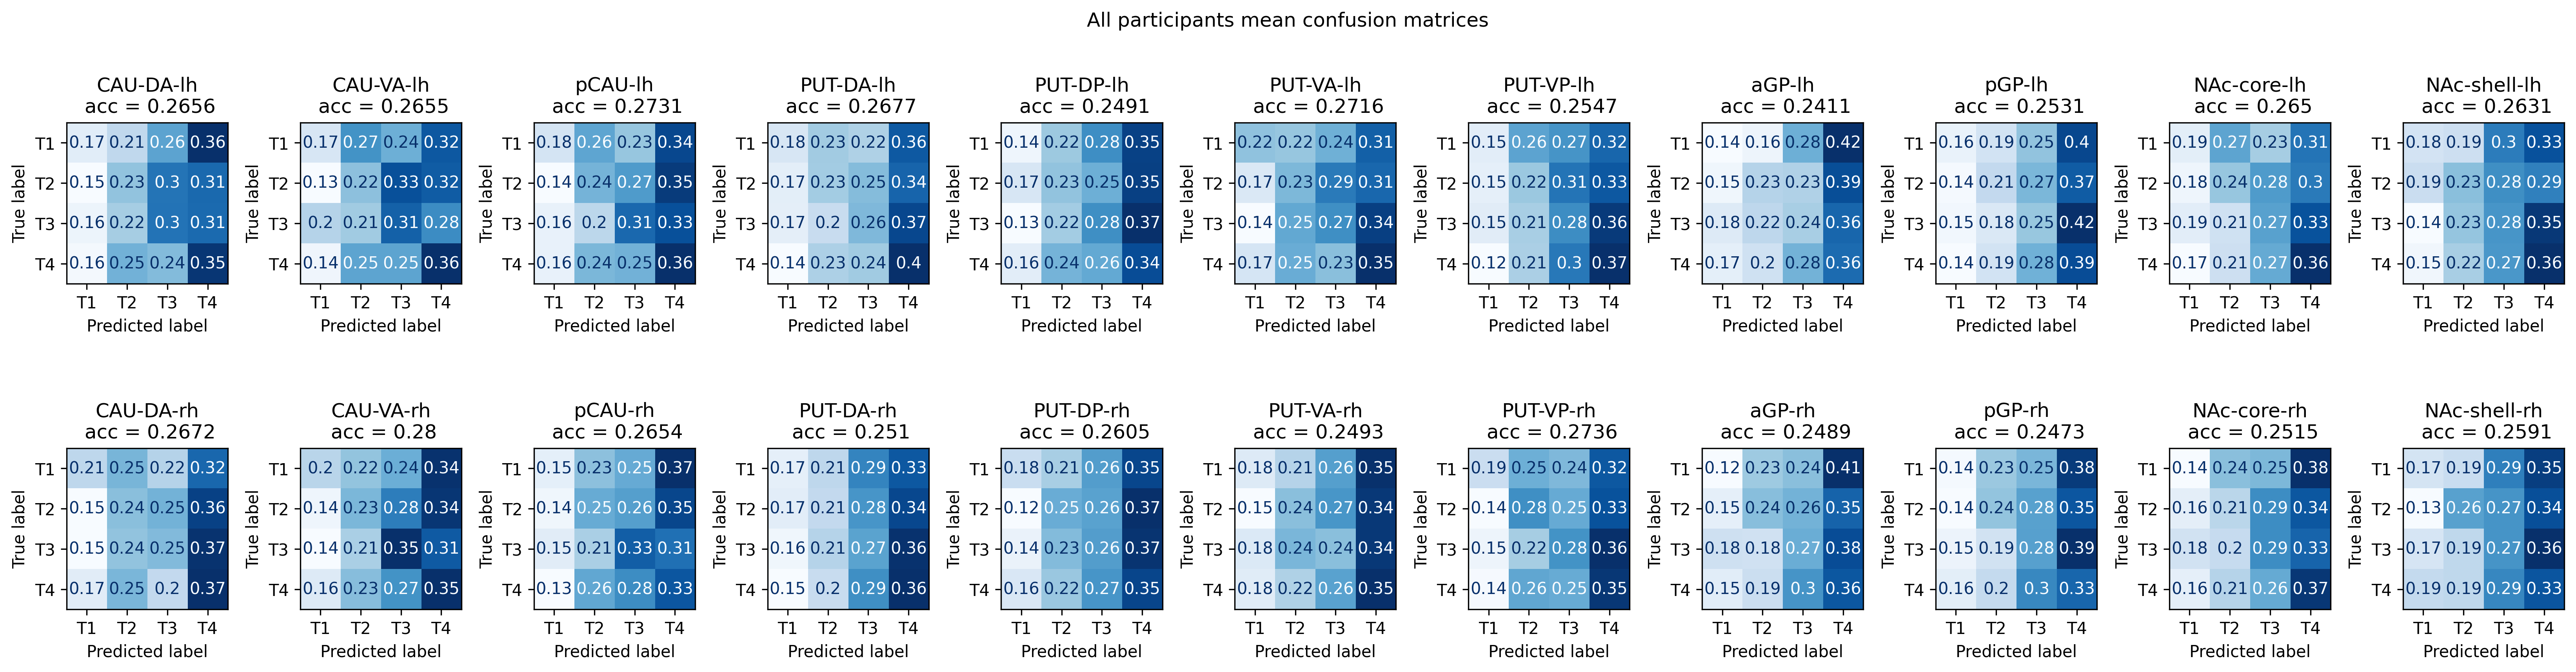

In [46]:

# All participants
fig2, axs = plt.subplots(nrows=2, ncols=round(num_rois/2), figsize=(num_rois,6), dpi=300)
fig2.suptitle('All participants mean confusion matrices')

for mx, mask_descrip in enumerate(roi_list):
    ax = plt.subplot(2, num_rois/2, mx + 1)
    ConfusionMatrixDisplay(all_cm_dict[mask_descrip],).plot(ax=ax, colorbar=False, 
                                                   im_kw={'cmap':'Blues', },
                                                   include_values=True)
    roi_mean = np.diag(all_cm_dict[mask_descrip]).mean()
    ax.set_title(f'{mask_descrip}\n acc = {roi_mean:.04}')
    ax.set_xticklabels(['T1','T2','T3','T4'])
    ax.set_yticklabels(['T1','T2','T3','T4'])
# better spacing
fig2.tight_layout()
fig2.savefig(l2_dir + '/' + f'group-all_{network_name}_split-{split_design}_label-tone_incl-vals_confusion_matrices.png')

### Compare with behavior

In [109]:
from scipy.stats import spearmanr

In [ ]:
for sub_id in sub_list:
    print(sub_id)
    behav_cm = np.genfromtxt('behav_confusion_matrices/sub-{}_behav_confusion_matrix.csv'.format(sub_id))    
    behav_off_diag = behav_cm[np.where(~np.eye(behav_cm.shape[0],dtype=bool))]
    #print(behav_off_diag)
    for mx, mask_descrip in enumerate(roi_list):
        mask_cm = np.genfromtxt('striatal_confusion_matrices/sub-{}_mask-{}_label-{}_confusion_matrix.csv'.format(sub_id, mask_descrip, 'tone'))
        mask_off_diag = mask_cm[np.where(~np.eye(mask_cm.shape[0],dtype=bool))]
        #print(mask_off_diag)
        
        r, p = spearmanr(behav_off_diag, mask_off_diag)
        print('{} r = {:.03f} p = {:.03f}'.format(mask_descrip, r, p))